### Deep reinforcement learning - Homework 2
#### Daniel Kuknyo
​You are in Esztergom and you need to go to Pest as fast as you can. There are two roads where you can leave the city, route 10 and 11.  
After you arrive to Buda, you have only two bridges you can choose from to cross the river Danube and arrive to Pest.  
The traffic is unpredictable, so it can happen that the road or bridge, you choose has a traffic jam. 

The time you need to cross the bridges depends on the first action (route 10 or 11), so they will be different either case.  
And sometimes you are redirected even though you have chosen the other route/bridge. 

Your goal is to build a strategy, where you gain the most reward on your journey. 
Reward are the negative time you need to go through that road/bridge.

For states: A,B,C and all actions the reward equals:  
R(State, Action) = { if there is a jam, Reward_jam, if there is normal traffic, Reward_normal, P_jam is given} 

It could happen that you choose to go in a direction, but you are redirected to the other (see  MDP example in Lecture 2.)​  
In example: P(s,a,s') = 0.9 so 90% of the time you go to the direction you choose, but 10% of the time you are redirected to the other action.

Tasks:  
1.Optimize your strategy to gain as much reward as you can  
2.Implement DP, MC and TD algorithms and compare their results  
3.Write a short (few sentences) study why they perform different.  
4.Run simulation for each of the for 1000 episodes  
5.Create graphs about the different algorithms performance. (use matplotlib)  
6.Finish these tasks for both sets of input data  
7.Experimenting have to be done in Python, and HW hand in as a Jupyter notebook (.ipynb)  
8.Input data can be found in .csv file in this module. 

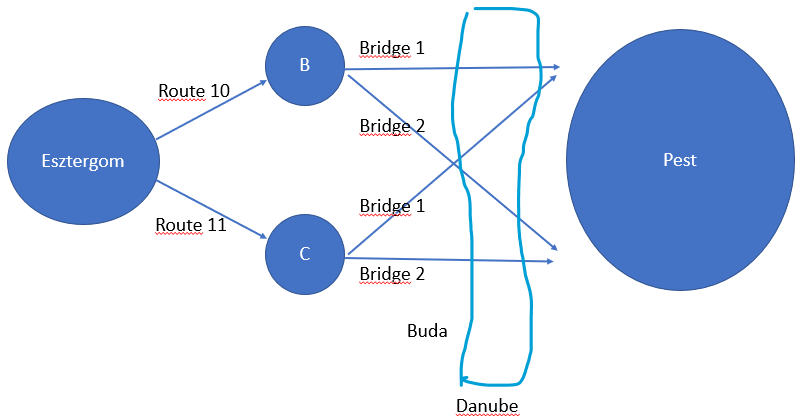

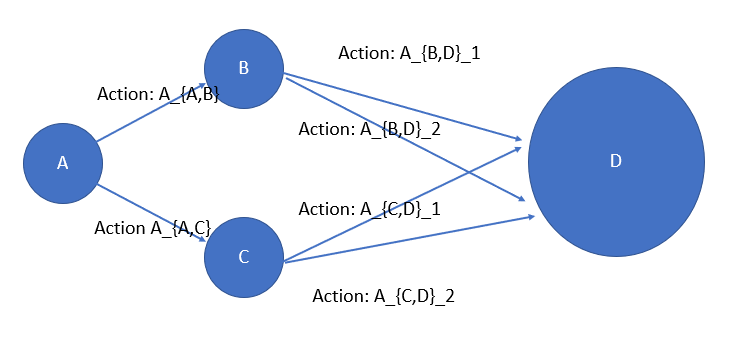

In [37]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Read input data

In [38]:
# Read the input and keep only the relevant columns
inputData = pd.read_csv('Homework_2_input_data.csv', sep=',')
inputData.rename(columns = {'Unnamed: 0': 'Name'}, inplace=True) 
inputData[inputData['Name'] == 'Y80L35']
rewards = inputData[[(x in ['Neptun', 'Y80L35']) for x in inputData['Name']]].copy()

get_rew = lambda c: dict(zip(rewards.iloc[:,[(c in x) for x in rewards.columns]].iloc[0,:], 
                             rewards.iloc[:,[(c in x) for x in rewards.columns]].iloc[1,:])) 

rewards_c1 = get_rew('CASE_1')
rewards_c2 = get_rew('CASE_2')

### Define a class for the environment. 
This will give the agent rewards based on the probabilities

In [39]:
class environment:
    def __init__(self, rewards): # Setup the environment based on rewards data
        Predirs = {}
        Pjams = {}
        RewJams = {}
        RewNorms = {}
    
        for x in rewards.keys():
            num = float(rewards[x])
            splitter = x.split('{')[1].split('}')[0]
            temp = [splitter[0], splitter[2]]

            if('1' in x):
                temp.append(1)
            elif('2' in x):
                temp.append(2)
            else:
                temp.append(0)
            temp = tuple(temp)

            if('State' in x):
                Predirs[temp] = num
            elif('Pjam' in x):
                Pjams[temp] = num
            elif('Reward_jam' in x):
                RewJams[temp] = num
            elif('Reward_normal' in x):
                RewNorms[temp] = num
        
        stateSet = set()
        stateSetTerm = set()
        for x in Predirs.keys():
            stateSet.add(x[0])
            stateSetTerm.add(x[0])
            stateSetTerm.add(x[1])
        stateSet = sorted(list(stateSet))
        
        # State Probability, next state, Terminated
        P = {}
        for x in Predirs.keys():
            s = x[0]
            terminated = False
            if(x[1]=='D'):
                terminated = True
            
            vals = tuple([Predirs[x], x[1], terminated])
            if(s in P.keys()):
                P[s][x] = vals 
            else:
                P[s] = {x:vals}
        
        self.Predirs = Predirs # Probabilities of redirection
        self.Pjams = Pjams # Probabilities of jamming
        self.RewJams = RewJams # Rewards for jamming
        self.RewNorms = RewNorms # Normal rewards
        self.Actions = [x for x in Predirs.keys()] # Set of Actions 
        self.States = stateSet # Set of States
        self.StatesTerm = stateSetTerm # Stet of States including terminal state
        self.nS = len(self.States) # Number of States
        self.nA = len(self.Actions) # Number of Actions
        self.P = P # Probabilities of States
        self.s = 'A' # Current state initialization to 'A' s0
        self.terminated = False # Episode is terminated or not init:False
        
    def get_reward(self, s, sp, a=0): # This function will return a reward depending on current/next state 
        # Create the action defining tuple
        sas = tuple([s, sp, a])
        reward = 0
        
        # Decide if we are being redirected
        Predir = self.Predirs[sas]
        p = np.random.rand()
        if(p > Predir): # Redirected
             for x in self.Actions:
                    if(x[0] == sas[0] and (x[1] != sas[1] or x[2] != sas[2])):
                        sas = x # Assign new value to chosen action 
                        break
        
        # Decide if road is jammed
        Pjam = self.Pjams[sas]
        p = np.random.rand()
        if(p < Pjam): # Jammed
            reward = self.RewJams[sas]
        else: # Not jammed
            reward = self.RewNorms[sas]
        
        next_state = sas[1]
        
        return reward, next_state    
    
    def get_random_policy(self, random=True, ones=False): # Create a policy for the agent to use. Random->True:normal/False:0
        P = {}
        for x in self.Predirs.keys():
            s = x[0]
            val=0
            if(random):
                val = np.random.rand()
            if(ones):
                val = 1
            
            if(s in P.keys()):
                P[s][x] = val 
            else:
                P[s] = {x:val}
        return P
    
    def get_best_choice(self, values_dict, key_return=True): # Get the best action or state depending on a policy
        keys = list(values_dict.keys())
        values = list(values_dict.values())
        min_v = np.min(values)
        values = [x if x!= 0 else min_v-1 for x in values]
        argm = np.argmax(values)
        if(key_return): 
            return keys[argm]
        else:
            return values[argm]
    
    def get_greedy_update(self, policy, state, action): # Update the policy greedily. Needed for opt. 
        P = policy
        for x in P[state].keys(): # Iterate over the actions
            if(x == action):
                P[state][x] = 1 # Set the probability to 100%
            else:
                P[state][x] = 0 
        return P
                
    def get_empty_state_value(self): # Get an empty array for the State-Value function
        return {x:0 for x in self.States}
    
    def get_empty_state_value_term(self, random=True): # Get an empty State-Value function for all states including the terminal state
        if(random): # Random for all states except terminal
            return {x:(np.random.rand() if x in self.States else 0) for x in self.StatesTerm} 
        else: # 0 for all states
            return {x:0 for x in self.StatesTerm}
    
    def get_empty_returns_value(self, terminal_state=False):
        if(terminal_state):
            return {x:[] for x in self.StatesTerm}
        else:
            return {x:[] for x in self.States}
    
    def get_empty_action_value(self): # Get an empty array for the Action-Value function
        return {x:0 for x in self.Actions}
    
    def reset(self): # Resets the environment to the initial state and returns it
        self.s = 'A'
        self.terminated = False
        return self.s
        
    def step(self, action): # Takes a step in the environment and returns [next_state, reward, terminated]
        state = action[0]
        next_state = action[1]
        a = action[2]
        
        reward, next_state = self.get_reward(state, next_state, a)
        
        if(next_state=='D'):
            self.terminated = True
        else:
            self.terminated = False
        
        return next_state, reward, self.terminated
    
    def generate_episode(self, policy): # Plays a single episode and returns a state-reward structure
        track = []
        terminated = False
        state = self.reset()
        reward = 0
        episode_reward = 0
        track.append((state, reward))
        
        while not terminated:
            action = self.get_best_choice(policy[state], key_return=True) # Choose the best action according to the policy
            state, reward, terminated = self.step(action) # Perform an action and get environment change
            track.append((state, reward))
            episode_reward += reward
            
        return track, episode_reward
    
    def play_episodes(self, n_episodes, policy): # Play any number of episodes based on a policy
        track = []
        total_reward = 0
        for episode in range(n_episodes):
            _, episode_reward = self.generate_episode(policy) # Play a single episode
            total_reward += episode_reward # Collect reward
            track.append(total_reward / (episode+1)) # Append current episode average reward to the tracking data structure
            
        average_reward = total_reward / n_episodes
        return total_reward, average_reward, track

In [40]:
def print_lst(lst): # A simple function to print rewards
    if(type(lst) == list):
        for x in lst:
            print(x)
    else:
        for x in lst.keys():
            print(x, ':', lst[x])
    print()

env = environment(rewards_c1)    

flag = 0 # Switch to simply print out all variables

if(flag==1):
    print_lst(env.Predirs)
    print_lst(env.Pjams)
    print_lst(env.RewJams)
    print_lst(env.RewNorms)
    print_lst(env.Actions)
    print_lst(env.States)
    print_lst(env.P)

In [41]:
del env

### Dynamic programming
#### Policy evaluation
Policy: an action --> action probability mapping

In [42]:
def policy_evaluation(policy, environment, discount_factor=1.0, theta=1e-9, max_iterations=1e9):
    evaluation_iterations = 1 # Keep track of eval iterations
    V = environment.get_empty_state_value_term(random=False) # Keep track of State-Value function 
    
    for i in range(int(max_iterations)): # Keep going until change is below the threshold or reached maximum number of iterations
        delta = 0 # Initialize a change of value function as zero
        
        for state in environment.States: # Go over each state
            v = 0 # A new value starting at 0 for current state
           
            for action in policy[state]: # Try all possible actions from this state (that are possible)
                action_probability = policy[state][action]
                reward, next_state = environment.get_reward(state, action[1], action[2])
                state_probability, next_state, terminated = environment.P[state][action] # How good will the next state be
                v += action_probability * state_probability * (reward + discount_factor * V[next_state]) # Calculate the value
           
            delta = max(delta, np.abs(V[state] - v)) # Absolute change of value function
            V[state] = v # Update value function
        
        evaluation_iterations += 1
        
        if delta < theta: # Exit loop if value change is insignificant
            # print(f'Policy evaluated in {evaluation_iterations} iterations.') # For debugging
            return V

#### Policy improvement

In [43]:
def one_step_lookahead(environment, state, V, discount_factor): # Look one step ahead from a state and evaluate Action-Value function
    action_values = environment.get_empty_action_value()
    for action in environment.P[state]:
        state = action[0]
        reward, next_state = environment.get_reward(state, action[1], action[2])
        state_probability, next_state, terminated = environment.P[state][action]
        action_values[action] += state_probability * (reward + discount_factor * V[next_state])
    return action_values

#### Policy iteration

In [44]:
def policy_iteration(environment, discount_factor=0.8, max_iterations=1e9):
    evaluated_policies = 1 # Set counter for number of evaluated policies
    policy = environment.get_random_policy(random=False, ones=True) # Get a random policy from the environment
    
    for i in range(int(max_iterations)): # Repeat until convergence or critical number of iterations reached
        stable_policy = True
        V = policy_evaluation(policy, environment, discount_factor=discount_factor) # Evaluate current policy
        
        for state in environment.States: # Go through each state and try to improve actions that were taken (policy Improvement)
            current_action = environment.get_best_choice(policy[state]) # Choose the best action in a current state under current policy
            action_value = one_step_lookahead(environment, state, V, discount_factor) # Evaluate if current action is optimal lookahead
            best_action = environment.get_best_choice(action_value) # Select a better action
            
            if current_action != best_action: # If action didn't change
                stable_policy = False
                policy = environment.get_greedy_update(policy, state, best_action)
        
        evaluated_policies += 1
        
        if stable_policy: # If the algorithm converged and policy is not changing anymore, then return final policy and value function
            print(f'Evaluated {evaluated_policies} policies.')
            return policy, V

#### Value iteration

In [45]:
def value_iteration(environment, discount_factor=0.8, theta=1e-15, max_iterations=1e9):
    V = environment.get_empty_state_value_term(random=False) # Initialize state-value function with zeros for each environment state

    for i in range(int(max_iterations)):
        delta = 0 # Early stopping condition

        for state in environment.States: # Update each state
            action_value = one_step_lookahead(environment, state, V, discount_factor) # Lookahead for action values 
            best_action_value = environment.get_best_choice(action_value, key_return=False) # Select best action wrt the highest s-a value
            delta = max(delta, np.abs(V[state] - best_action_value)) # Calculate change in value
            V[state] = best_action_value # Update the value function for current state

        if delta < theta: # Check if we can stop
            print(f'Value-iteration converged at iteration {i}.')
            break

    policy = environment.get_random_policy(random=False) # Empty policy for the Value Function
    
    for state in environment.States: # Create a deterministic policy using the optimal value function
        action_value = one_step_lookahead(environment, state, V, discount_factor) # Lookahead for best action
        best_action = environment.get_best_choice(action_value, key_return=True) # Select best action based on the highest State-Action value
        policy[state][best_action] = 1.0 # Update the policy to perform the best action under current state
    return policy, V

#### Run dynamic programming

In [46]:
def run_learning_DP(rewards_c, solvers, discount_factor, name):
    print('-----Starting simulation for ' + name + '-----') 
    tracks = {}
    V_tracks = {}
    for iteration_name, iteration_func in solvers:
        env = environment(rewards_c) # Load an environment
        policy, V = iteration_func(env, discount_factor) # Search for an optimal policy using policy iteration
        V_tracks[iteration_name] = V
        
        total_reward, average_reward, total_track = env.play_episodes(n_episodes, policy) # Apply best policy to the real environment
        
        tracks[iteration_name] = total_track
        print(f'{iteration_name}: average reward over {n_episodes} episodes = {average_reward} \n\n')
    return tracks, V_tracks

In [47]:
n_episodes = 10000 # Number of episodes to play
discount_factor = 0.8 # Discount rate for learning

solvers = [('Policy Iteration', policy_iteration), ('Value Iteration', value_iteration)] # Which approaches to try

tracks_c1_DP, V_tracks_c1_DP = run_learning_DP(rewards_c1, solvers, discount_factor, 'CASE 1')

tracks_c2_DP, V_tracks_c2_DP = run_learning_DP(rewards_c2, solvers, discount_factor, 'CASE 2')

-----Starting simulation for CASE 1-----
Evaluated 5 policies.
Policy Iteration: average reward over 10000 episodes = -47.5684 


Value-iteration converged at iteration 51.
Value Iteration: average reward over 10000 episodes = -47.5827 


-----Starting simulation for CASE 2-----
Evaluated 14 policies.
Policy Iteration: average reward over 10000 episodes = -61.7077 


Value-iteration converged at iteration 32.
Value Iteration: average reward over 10000 episodes = -60.3494 




#### Plot the results

In [48]:
def plot_results(results, title, solvers=None):
    plt.figure(figsize=(10,8))
    min_len = min([len(results[eps]) for eps in results.keys()])
    
    if(solvers is None): # For Temporal differences and Monte Carlo
        for i, eps in enumerate(results.keys()):
            plt.plot(results[eps][:min_len], label=eps) # Add the name of the state as a legend (for MC plotting) 
    else: # For Dynamic programming
        for i, eps in enumerate(results.keys()):
            plt.plot(results[eps][:min_len], label=solvers[i][0]) # Add the name of the solver as a legend
    
    plt.title("Average rewards over episodes: "+title, size=15)
    plt.xlabel("Iterations", size=12)
    plt.ylabel("Average rewards", size=12)
    plt.legend()
    plt.show()    

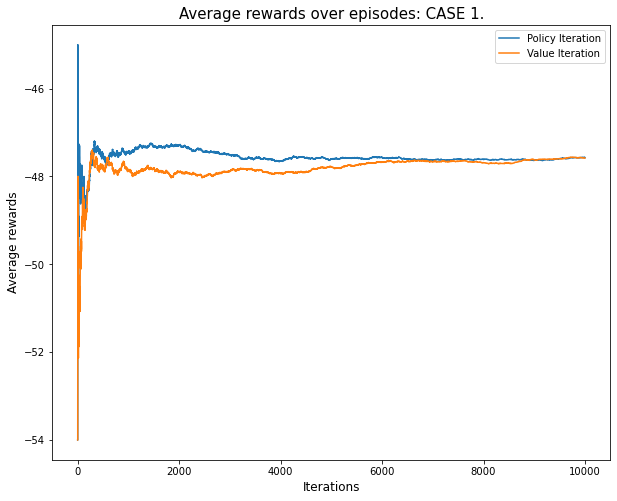

In [49]:
plot_results(tracks_c1_DP, "CASE 1.", solvers)

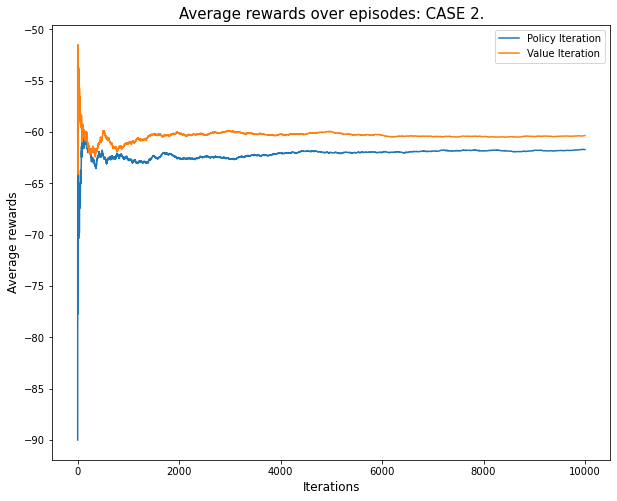

In [50]:
plot_results(tracks_c2_DP, "CASE 2.", solvers)

### Monte Carlo 

In [51]:
def first_visit_MC(environment, discount_factor=0.8, theta=1e-15, max_iterations=1e9):
    V = environment.get_empty_state_value() # State-value function
    V_track = environment.get_empty_returns_value() # State-value function
    returns = environment.get_empty_returns_value() # Empty list for all sES
    
    for i in range(int(max_iterations)):
        policy = environment.get_random_policy(random=True) # Policy to be evaluated
        episode, _ = environment.generate_episode(policy) # Generate an episode using the policy
        G = 0
        
        for j in range(len(episode)-2, -1, -1):
            st = episode[j][0] # S(t)
            Rtp1 = episode[j+1][1] # R(t+1)
            G = discount_factor * G + Rtp1 # Calculate gain
            visited_states = {episode[i][0] for i in range(len(episode)-1)} # Check which states were visited
            
            if(st in visited_states):
                returns[st].append(G)
                V[st] = np.mean(returns[st])
                V_track[st].append(V[st])
                
    return V, V_track

#### Run Monte Carlo

{'A': -61.27808000000002, 'B': -40.886103870062165, 'C': -28.53640534610014} 



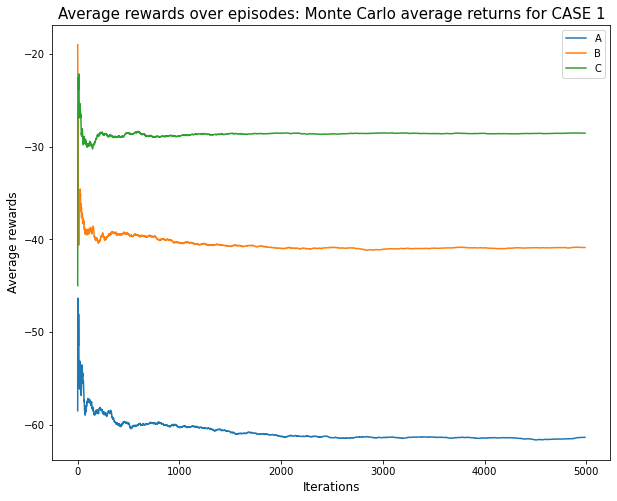

In [52]:
env_c1 = environment(rewards_c1)
V_c1_MC, V_track_c1_MC = first_visit_MC(env_c1, discount_factor=0.9, max_iterations=10000)
print(V_c1_MC, "\n")
plot_results(V_track_c1_MC, "Monte Carlo average returns for CASE 1")

{'A': -69.17473999999999, 'B': -34.391352305316566, 'C': -31.752332174867387} 



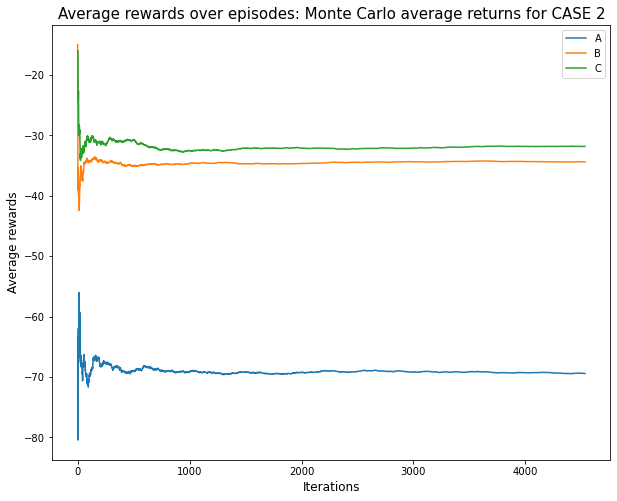

In [53]:
env_c2 = environment(rewards_c2)
V_c2_MC, V_track_c2_MC = first_visit_MC(env_c2, discount_factor=0.9, max_iterations=10000)
print(V_c2_MC, "\n")
plot_results(V_track_c2_MC, "Monte Carlo average returns for CASE 2")

### Temporal Difference Methods

In [54]:
def temporal_difference(environment, discount_factor=1.0, step_size=0.8, max_iterations=1e9):
    V = environment.get_empty_state_value_term()
    V_track = environment.get_empty_returns_value(terminal_state=True)
    V_mean_track =  environment.get_empty_returns_value(terminal_state=True)
    
    for episode in range(int(max_iterations)):
        policy = environment.get_random_policy(random=True)
        S = environment.reset()
        terminated = environment.terminated
        
        while not terminated:
            A = environment.get_best_choice(policy[S], key_return=True)
            next_state, reward, terminated = environment.step(A)
            V[S] = V[S] + step_size * (reward + discount_factor * V[next_state] - V[S])
            V_track[S].append(V[S])
            V_mean_track[S].append(np.mean(V_track[S])) 
            S = next_state
            
    V = dict(sorted(V.items(), key=lambda x:x[1]))
    V_mean_track.pop('D', None)
    V.pop('D', None)
    return V, V_mean_track

#### Run Temporal Difference

In [55]:
V_c1_TD, V_track_c1_TD = temporal_difference(env_c1, discount_factor=0.8, step_size=0.7, max_iterations=1000)
V_c2_TD, V_track_c2_TD = temporal_difference(env_c2, discount_factor=0.8, step_size=0.7, max_iterations=1000)

print('State-Value function for CASE 1 using Temporal Differences\n', V_c1_TD,'\n')
print('State-Value function for CASE 2 using Temporal Differences\n', V_c2_TD)

State-Value function for CASE 1 using Temporal Differences
 {'B': -49.506091485213354, 'C': -37.523387491693086, 'A': -36.230028390973345} 

State-Value function for CASE 2 using Temporal Differences
 {'A': -80.94855619116373, 'B': -34.44516859100227, 'C': -23.445609956712904}


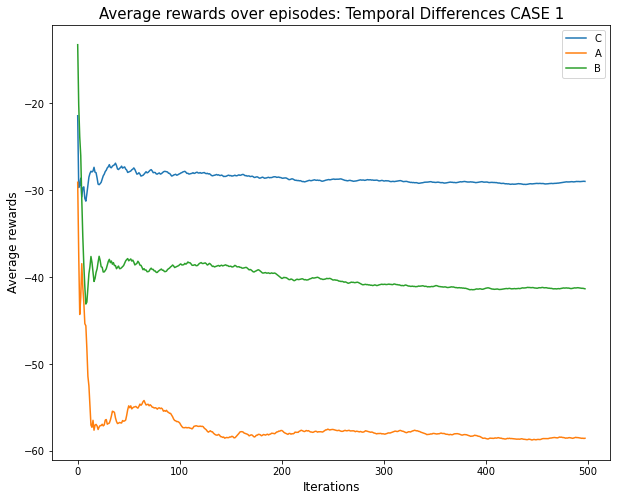

In [56]:
plot_results(V_track_c1_TD, 'Temporal Differences CASE 1') 

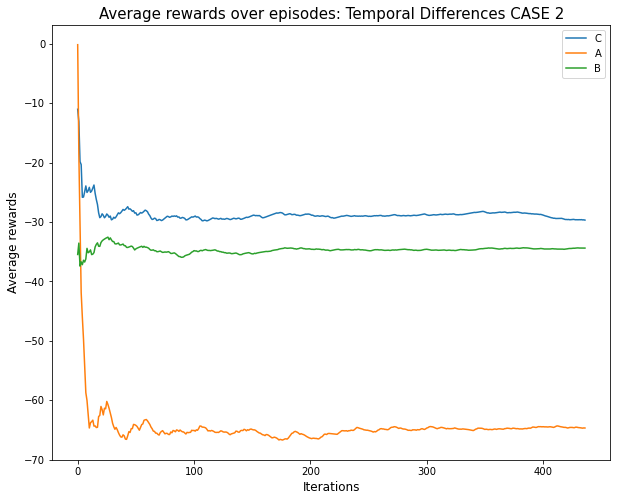

In [57]:
plot_results(V_track_c2_TD, 'Temporal Differences CASE 2')

### Comparing value functions

In [58]:
 # DP policy iteration, DP value iteration, Monte Carlo, Temporal Differences
def compare_value_f(lst, name, bar_width=0.15, colors=['r','g','b']):    
    plt.figure(figsize=(8,8))
    all_states = set()
    for x in lst.keys(): # Sort all dicts by name
        lst[x] = dict(sorted(lst[x].items(), key=lambda k:k[1]))
    for x in lst.keys():
        for y in list(lst[x].keys()):
            if(lst[x][y]==0):
                lst[x].pop(y, None)
            else:
                all_states.add(y)
    all_states = sorted(list(all_states))
    for i,x in enumerate(lst.keys()):
        names = list(lst[x].keys())
        vals = list(lst[x].values())
        plt.bar(np.arange(len(names))+(bar_width*i), vals, width=bar_width, label=x)
    
    plt.title('Comparison of Value functions '+name, size=15)
    plt.xlabel('State',size=12)
    plt.ylabel('Value',size=12)
    max_len = len(lst)
    plt.xticks(np.arange(2*bar_width,3-bar_width), all_states)
    plt.legend(fontsize=12)
    plt.show()

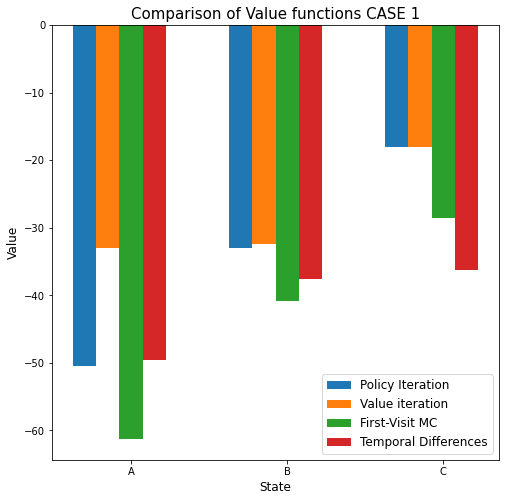

In [59]:
names = ['Policy Iteration','Value iteration','First-Visit MC','Temporal Differences'] # Names of algorithms
values = [V_tracks_c1_DP['Policy Iteration'], V_tracks_c1_DP['Value Iteration'], V_c1_MC, V_c1_TD]
lst = {x:y for x,y in zip(names, values)}
compare_value_f(lst, 'CASE 1')

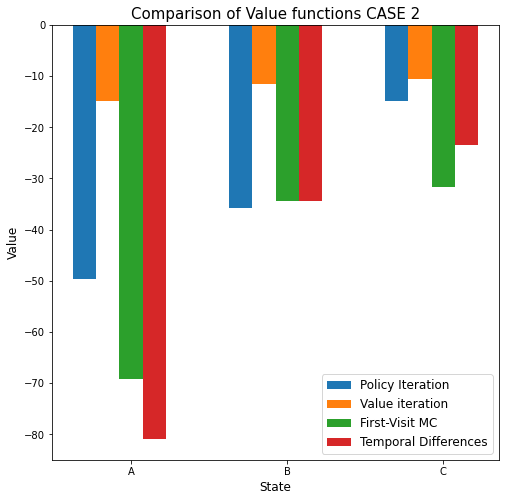

In [60]:
values = [V_tracks_c2_DP['Policy Iteration'], V_tracks_c2_DP['Value Iteration'], V_c2_MC, V_c2_TD]
lst = {x:y for x,y in zip(names, values)}
compare_value_f(lst, 'CASE 2')

### Study: Why do these algorithms all perform different?
We have previously seen value functions comparisons and a deep analysis of how the average rewards converge while running policy iteration, value iteration, monte carlo and temporal difference learning. They all have different performances because they all do the searching of the backup in a different way.  
Policy and Value iteration both start from a given state and from there check all possible states, and evaluate how good they are given that the agent is in a given state. This yielded better results in most of my experience, because how these methods utilize the dynamics of the environment to calucalate the values of state-value functions.  
Monte Carlo estimation is fast and powerful because it doesn't need to know the probabilities of states and actions. It can learn from pure experience by sampling complete episodes. By this MC is doing a depth search. 
Temporal Difference learning samples a single step at a time and builds the model by sampling that single step. It is also not necessary to know the transition and action probabilities. The performance of MC and TD were very similar in most cases.  
  
Regarding the comparison of the value functions, we can note that policy and value iterations were close to eachother in value in almost all the cases. The MC and TD algorithms were also performing in a similar fashion. 
In the second case, where there was a specific chance of derouting the agent to a different state, yielded less total reward than in the first case. This uncertainity made the non-model-based algorithm perform worse than the model-based ones. In the first case the learning always exited with a larger average reward, because there was less unsureness in the rewarding system. This being said, we can surely note that all the algorithms converged, and the learning yielded a sure solution in all the cases. This is concluded as a success. 